In [2]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Various tests on individual functions

## Initial velocity limits

In [12]:
# conversion factor for limits
m = 0.05*unit.eV
cf = my.T_nu_eV.to(unit.J) / m.to(unit.kg, unit.mass_energy()) / const.c

# limits on velocity
lower = 0.01 * cf.to(unit.km/unit.s)
upper = 10 * cf.to(unit.km/unit.s)

print(lower, upper)
print(lower.to(my.Uunit), upper.to(my.Uunit))

10.075304928248277 km / s 10075.304928248277 km / s
3.265183954630376e-16 kpc / s 3.265183954630376e-13 kpc / s


## Simulated momenta to eV

In [35]:
m_nu = 0.05*unit.eV
u0 = np.abs(np.load(f'neutrino_vectors/nu_100.npy')[0][3:6])*unit.kpc/unit.s
print(u0)

p0 = u0 * m_nu.to(unit.kg, unit.mass_energy())
p0 = p0.to(unit.kg*unit.m/unit.s)
print(p0)

cf = (1/5.344286e-19)*const.c.value
p0_eV = p0.value * cf * unit.eV
print(p0_eV)

y = p0_eV / my.T_nu_eV
print(y)

[3.26513094e-15 0.00000000e+00 3.26502211e-13] kpc / s
[8.98028543e-33 0.00000000e+00 8.97998608e-31] kg m / s
[5.03757067e-06 0.00000000e+00 5.03740275e-04] eV
[0.02997876 0.         2.99777598]


## 1/hc to cm^-1/eV

In [11]:
hc_neg1 = (1/const.h/const.c).to(1/unit.cm/unit.eV)
print(hc_neg1)

8065.543937349209 1 / (cm eV)


## Table 1

In [5]:
print('R_vir:', fct.R_vir(0, my.Mvir_NFW))
print('scale_radius:', fct.scale_radius(0, my.Mvir_NFW))

R_vir: 333.69416698906537 kpc
scale_radius: 19.911585976259072 kpc


## Critical Density

In [6]:
crit = fct.rho_crit(0)
print('Check if this matches critical density of universe today:')
print(crit.to(unit.kg/unit.m**3))

Check if this matches critical density of universe today:
8.598814256622896e-27 kg / m3


## Unit Conversion Tests

In [7]:
print(my.T_nu.to(unit.eV, unit.temperature_energy()))

0.00016803799861183098 eV


## Derivative vector values

In [8]:
z = 0
x_i = np.array([8.5,0.,0.])*unit.kpc

t2 = fct.dPsi_dxi_NFW(x_i, z, my.rho0_NFW, my.Mvir_NFW)
print(type(t2), t2)

<class 'astropy.units.quantity.Quantity'> [2.33716425e-29 0.00000000e+00 0.00000000e+00] kpc / s2


## Time Variable s

In [3]:
s = fct.s_of_z(4)
print('Value of time variable s in seconds at redhshift 4','\n', s)

h_s = my.H0.to(1/unit.s)
print('Age of universe in seconds:','\n', 1/h_s)

Value of time variable s in seconds at redhshift 4 
 7.548019506838111e+17
Age of universe in seconds: 
 4.560563969097499e+17 s


## Plot for s and z relation

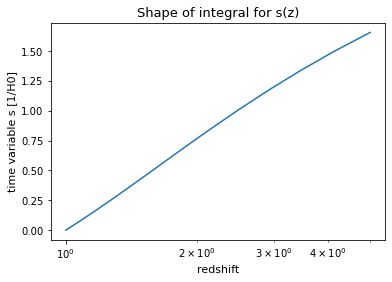

In [9]:
zeds = np.geomspace(1e-10, CC.Z_STOP, CC.Z_AMOUNT)

ss = np.array([fct.s_of_z(z) for z in zeds]) * my.H0.to(unit.s**-1).value


plt.semilogx(1+zeds, ss)
plt.title('Shape of integral for s(z)')
plt.xlabel('redshift')
plt.ylabel('time variable s [1/H0]')
plt.savefig('check_plots/s_of_z_integral.pdf')

## Initial Velocities

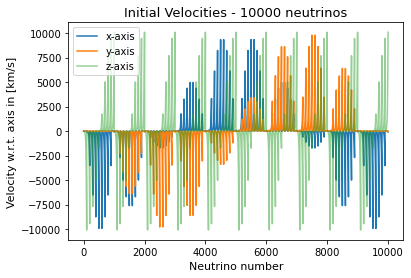

In [10]:
from backtracing import draw_ui

# Draw initial velocities.
ui = draw_ui(CC.PHIs, CC.THETAs, CC.Vs)*my.Uunit
ui = ui.to(unit.km/unit.s).value

ux = ui[:,0]
uy = ui[:,1]
uz = ui[:,2]

x = np.arange(len(ux))
y = np.arange(len(uy))
z = np.arange(len(uz))

plt.plot(x, ux, label='x-axis', )
plt.plot(y, uy, label='y-axis', )
plt.plot(z, uz, label='z-axis', alpha=0.5)
plt.title(f'Initial Velocities - {CC.NR_OF_NEUTRINOS} neutrinos')
plt.xlabel('Neutrino number')
plt.ylabel('Velocity w.r.t. axis in [km/s]')
plt.legend()
plt.savefig('check_plots/initial_velocities.pdf')